# Compare the precision of $R_{ZZ}(\phi) = \exp(-i \frac{\phi}{2} Z Z)$ at low $\phi$

Experiment:
Run $R_{ZZ}(\phi)$ for $0 < \phi < \frac{\pi}{2}$ (40 points). For each point, do a full process tomography.

- CNOT-based implementation
- Implementation in 2105.01063
- Linearized implementation

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import pprint

from qiskit import pulse, QuantumCircuit, transpile, IBMQ
from qiskit.circuit import Gate
from qiskit import schedule as build_schedule
from qiskit.circuit import Parameter
from qiskit.tools.monitor import job_monitor
from qiskit.visualization.pulse_v2 import IQXDebugging

from pulse_experiment_utils import *

IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [2]:
provider = IBMQ.get_provider(hub='ibm-q-utokyo', group='internal', project='icepp')
backend = provider.get_backend('ibm_kawasaki')
#backend = provider.get_backend('ibmq_montreal')
#backend = provider.get_backend('ibmq_bogota')
#backend = provider.get_backend('ibmq_toronto')

In [3]:
control_qubit = 0
target_qubit = 1

backend_config = backend.configuration()
backend_defaults = backend.defaults()
dt = backend_config.dt
calibrations = backend_defaults.instruction_schedule_map

control_drive_channel = backend_config.drive(control_qubit)
target_drive_channel = backend_config.drive(target_qubit)
control_channel = backend_config.control((control_qubit, target_qubit))[0]

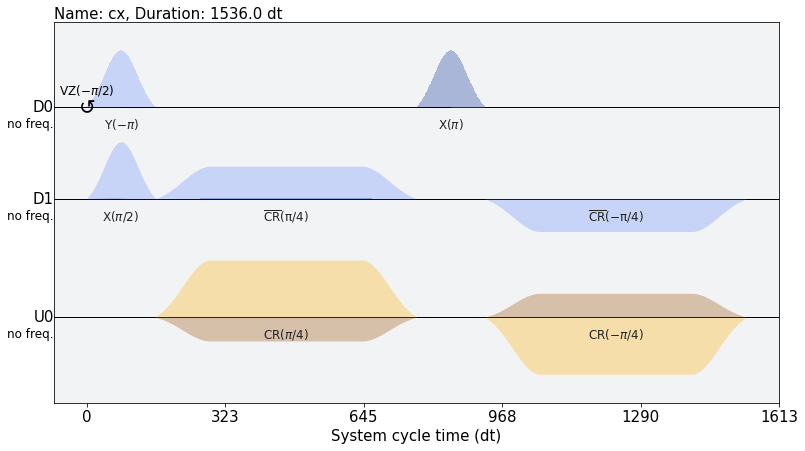

In [4]:
calibrations.get('cx', [control_qubit, target_qubit]).draw()

In [5]:
control_x_pulse = calibrations.get('x', [control_qubit]).instructions[0][1].pulse
target_x_pulse = calibrations.get('x', [target_qubit]).instructions[0][1].pulse
control_sx_pulse = calibrations.get('sx', [control_qubit]).instructions[0][1].pulse
target_sx_pulse = calibrations.get('sx', [target_qubit]).instructions[0][1].pulse
cx_sched = calibrations.get('cx', [control_qubit, target_qubit])
cr45_rotary_pulse = next(inst[1].pulse for inst in cx_sched.instructions if inst[1].name == 'CR90p_d{}_u{}'.format(target_drive_channel.index, control_channel.index))
cr45_pulse = next(inst[1].pulse for inst in cx_sched.instructions if inst[1].name == 'CR90p_u{}'.format(control_channel.index))

In [6]:
phi_values = np.linspace(0., np.pi / 2., 40)

In [7]:
def get_closest_multiple_of_16(num):
    return int(np.round(num / 16.)) * 16

In [8]:
initials = ['0', '1', '+', 'i']
axes = ['x', 'y', 'z']

## CNOT-based $R_{ZZ}$
### Template circuit

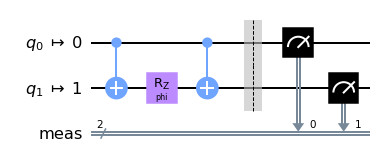

In [9]:
phi = Parameter('phi')

circuit = QuantumCircuit(2, 2)
circuit.cx(0, 1)
circuit.rz(phi, 1)
circuit.cx(0, 1)
circuit.measure_all()

circuit = transpile(circuit, backend=backend, initial_layout=[control_qubit, target_qubit])
circuit.draw('mpl', idle_wires=False)

In [10]:
cx_schedules = {}

for control_initial in initials:
    for target_initial in initials:
        for control_axis in axes:
            for target_axis in axes:
                name = control_initial + target_initial + control_axis + target_axis
                
                circuit = QuantumCircuit(2, 2, name=name)
                
                for iq, init in enumerate([control_initial, target_initial]):
                    if init == '1':
                        circuit.x(iq)
                    elif init == '+':
                        circuit.h(iq)
                    elif init == 'i':
                        circuit.sxdg(iq)
        
                circuit.cx(0, 1)
                circuit.rz(phi, 1)
                circuit.cx(0, 1)
                
                for iq, axis in enumerate([control_axis, target_axis]):
                    if axis == 'x':
                        circuit.h(iq)
                    elif axis == 'y':
                        circuit.sx(iq)
                        
                circuit.measure_all()

                circuit = transpile(circuit, backend=backend, initial_layout=[control_qubit, target_qubit])
                schedule = build_schedule(circuit, backend=backend)
                cx_schedules[name] = [schedule.assign_parameters({phi: phi_value}, inplace=False) for phi_value in phi_values]

## $R_{ZZ}$ from 2105.01063 (Pulse-efficient circuit transpilation)

In [11]:
cr = cr45_pulse
crr = cr45_rotary_pulse
sigma = cr.sigma
tail = (cr.duration - cr.width) // 2
tail_area = np.abs(cr.amp) * np.sqrt(np.pi / 2.) * sigma * scipy.special.erf(tail / np.sqrt(2.) / sigma)
cr45_area_norm = np.abs(cr.amp) * cr.width + 2. * tail_area
minimum_phi = 2. * np.pi / 4. * (2. * tail_area) / cr45_area_norm

### Template schedule

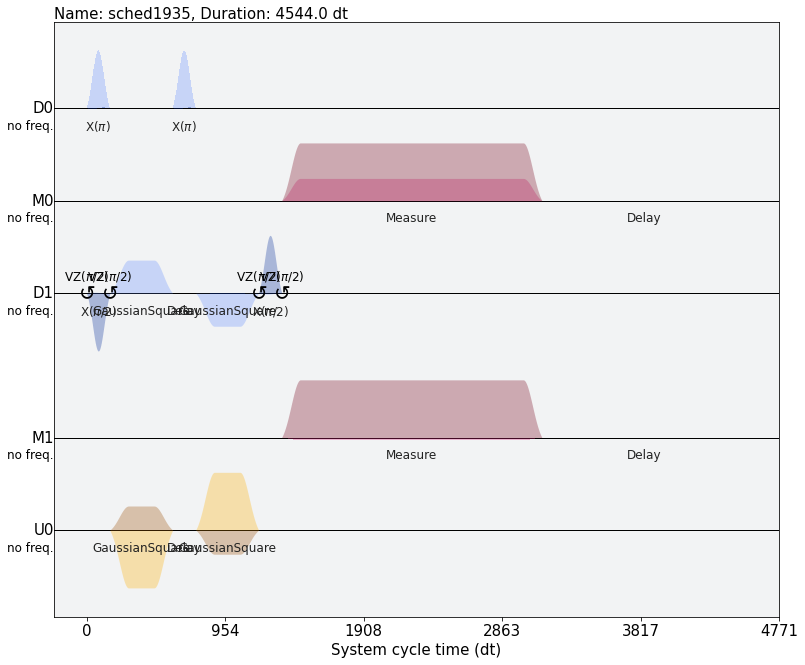

In [12]:
with pulse.build(backend=backend) as sched:
    # Hadamard
    pulse.shift_phase(-np.pi / 2., target_drive_channel)
    pulse.play(target_sx_pulse, target_drive_channel)
    pulse.shift_phase(-np.pi / 2., target_drive_channel)
    
    # Rzx
    gs_width = cr45_pulse.width // 2
    gs_duration = cr45_pulse.duration - (cr45_pulse.width // 2)
    
    ## echo
    pulse.play(control_x_pulse, control_drive_channel)
    
    with pulse.align_sequential():
        pulse.delay(0, control_drive_channel)
        pulse.delay(0, target_drive_channel)
        pulse.delay(0, control_channel)
        
    pulse.play(pulse.GaussianSquare(duration=gs_duration, amp=-(cr45_pulse.amp), sigma=sigma, width=gs_width), control_channel)
    pulse.play(pulse.GaussianSquare(duration=gs_duration, amp=-(cr45_rotary_pulse.amp), sigma=sigma, width=gs_width), target_drive_channel)
    
    with pulse.align_sequential():
        pulse.delay(0, control_channel)
        pulse.play(control_x_pulse, control_drive_channel)
        
    pulse.delay(control_x_pulse.duration, target_drive_channel)
    pulse.delay(control_x_pulse.duration, control_channel)
    
    ## forward
    pulse.play(pulse.GaussianSquare(duration=gs_duration, amp=cr45_pulse.amp, sigma=sigma, width=gs_width), control_channel)
    pulse.play(pulse.GaussianSquare(duration=gs_duration, amp=cr45_rotary_pulse.amp, sigma=sigma, width=gs_width), target_drive_channel)

    # Hadamard
    pulse.shift_phase(-np.pi / 2., target_drive_channel)
    pulse.play(target_sx_pulse, target_drive_channel)
    pulse.shift_phase(-np.pi / 2., target_drive_channel)
    
    with pulse.align_sequential():
        pulse.delay(0, target_drive_channel)
        pulse.measure(qubits=[control_qubit, target_qubit], registers=[pulse.MemorySlot(0), pulse.MemorySlot(1)])
    
sched.draw()

In [13]:
pe_schedules = {}

for control_initial in initials:
    for target_initial in initials:
        for control_axis in axes:
            for target_axis in axes:
                name = control_initial + target_initial + control_axis + target_axis
                
                schedules = []
                for phi_value in phi_values:
                    with pulse.build(backend=backend, name=name) as sched:
                        if phi_value <= minimum_phi:
                            amp_ratio = phi_value / minimum_phi
                            duration = 2 * tail
                            cr_pulse = pulse.Gaussian(duration=duration, amp=(amp_ratio * cr.amp), sigma=sigma)
                            cr_rotary_pulse = pulse.Gaussian(duration=duration, amp=(amp_ratio * crr.amp), sigma=sigma)
                            cr_echo = pulse.Gaussian(duration=duration, amp=-(amp_ratio * cr.amp), sigma=sigma)
                            cr_rotary_echo = pulse.Gaussian(duration=duration, amp=-(amp_ratio * crr.amp), sigma=sigma)
                        else:
                            area = phi_value / 2. / (np.pi / 4.) * cr45_area_norm
                            width = (area - 2. * tail_area) / np.abs(cr.amp)
                            duration = get_closest_multiple_of_16(width + 2 * tail)
                            cr_pulse = pulse.GaussianSquare(duration=duration, amp=cr.amp, sigma=sigma, width=width)
                            cr_rotary_pulse = pulse.GaussianSquare(duration=duration, amp=crr.amp, sigma=sigma, width=width)
                            cr_echo = pulse.GaussianSquare(duration=duration, amp=-cr.amp, sigma=sigma, width=width)
                            cr_rotary_echo = pulse.GaussianSquare(duration=duration, amp=-crr.amp, sigma=sigma, width=width)
                          
                        if control_initial == '+':
                            # Hadamard
                            pulse.shift_phase(-np.pi * 0.5, control_drive_channel)
                            pulse.play(control_sx_pulse, control_drive_channel)
                            pulse.shift_phase(-np.pi * 0.5, control_drive_channel)
                        elif control_initial == 'i':
                            # Sxdg
                            pulse.shift_phase(-np.pi, control_drive_channel)
                            pulse.play(control_sx_pulse, control_drive_channel)
                            pulse.shift_phase(-np.pi, control_drive_channel)
                            
                        if target_initial == '1':
                            # X
                            pulse.play(target_x_pulse, target_drive_channel)
                        elif target_initial == 'i':
                            # Sxdg
                            pulse.shift_phase(-np.pi, target_drive_channel)
                            pulse.play(target_sx_pulse, target_drive_channel)
                            pulse.shift_phase(-np.pi, target_drive_channel)
                            
                        # Hadamard
                        if target_initial != '+':
                            pulse.shift_phase(-np.pi / 2., target_drive_channel)
                            pulse.play(target_sx_pulse, target_drive_channel)
                            pulse.shift_phase(-np.pi / 2., target_drive_channel)
                            
                        # Rzx
                        ## echo
                        if control_initial != '1':
                            pulse.play(control_x_pulse, control_drive_channel)

                        with pulse.align_sequential():
                            pulse.delay(0, control_drive_channel)
                            pulse.delay(0, target_drive_channel)
                            pulse.delay(0, control_channel)
                            
                        pulse.play(cr_echo, control_channel)
                        pulse.play(cr_rotary_echo, target_drive_channel)

                        with pulse.align_sequential():
                            pulse.delay(0, control_channel)
                            pulse.play(control_x_pulse, control_drive_channel)

                        pulse.delay(control_x_pulse.duration, target_drive_channel)
                        pulse.delay(control_x_pulse.duration, control_channel)

                        ## forward
                        pulse.play(cr_pulse, control_channel)
                        pulse.play(cr_rotary_pulse, target_drive_channel)
                        
                        with pulse.align_sequential():
                            pulse.delay(0, control_channel)
                            pulse.delay(0, control_drive_channel)

                        # Hadamard
                        if target_axis != 'x':
                            pulse.shift_phase(-np.pi / 2., target_drive_channel)
                            pulse.play(target_sx_pulse, target_drive_channel)
                            pulse.shift_phase(-np.pi / 2., target_drive_channel)

                        if control_axis == 'x':
                            pulse.shift_phase(-np.pi * 0.5, control_drive_channel)
                            pulse.play(control_sx_pulse, control_drive_channel)
                            pulse.shift_phase(-np.pi * 0.5, control_drive_channel)
                        elif control_axis == 'y':
                            pulse.play(control_sx_pulse, control_drive_channel)

                        if target_axis == 'y':
                            pulse.play(target_sx_pulse, target_drive_channel)
                            
                        with pulse.align_sequential():
                            pulse.delay(0, control_drive_channel, )
                            pulse.delay(0, target_drive_channel, )
                            pulse.measure(qubits=[control_qubit, target_qubit], registers=[pulse.MemorySlot(0), pulse.MemorySlot(1)])
                            
                    schedules.append(sched)
                        
                pe_schedules[name] = schedules

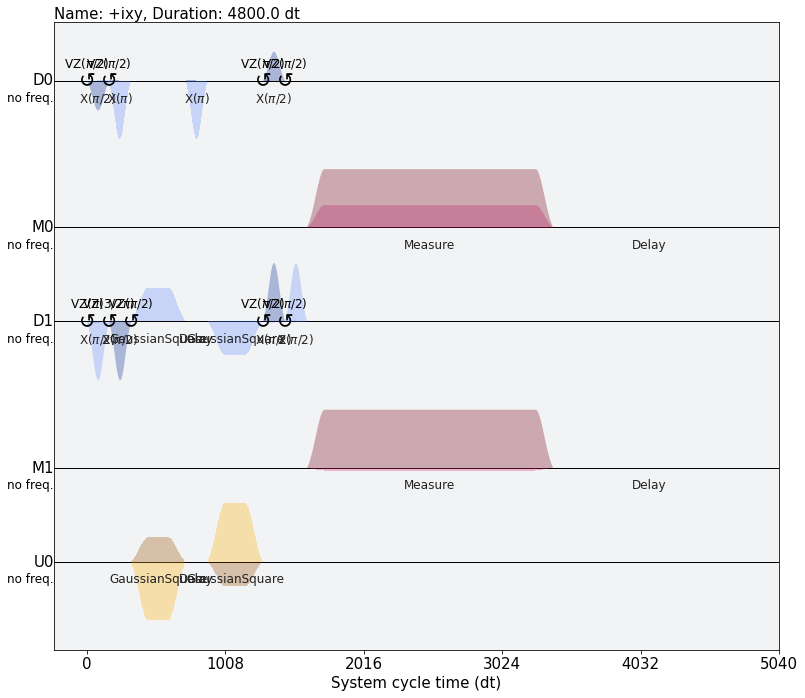

In [14]:
pe_schedules['+ixy'][23].draw()

## Linearized $R_{ZZ}$

First idea: Let GaussianSquare align itself with multiples of 16 by extending the tails. Calibration is for 2 sigma but having additional sigmas should not matter too much.

Second idea: Define a pulse shape class that adds an internal delay to make the overall duration a multiple of 16 while driving only with 2 sigmas

  -> Did not work; qiskit sends pulse class names and parameter values rather than the actual waveform.

In [15]:
class AlignedGaussianSquare(pulse.GaussianSquare):
    def __init__(self, pulse_duration, amp, sigma, width, name=None):
        residual = pulse_duration % 16
        if residual == 0:
            duration = pulse_duration
        else:
            duration = pulse_duration + 16 - residual
            
        pulse.GaussianSquare.__init__(self, duration, amp, sigma, width=width, name=name)
        self._risefall_sigma_ratio = (pulse_duration - self.width) / (2.0 * self.sigma)
        
        self.pulse_duration = pulse_duration

    def get_waveform(self):
        waveform = pulse.GaussianSquare.get_waveform(self)
        residual = self.pulse_duration % 16
        if residual != 0:
            waveform._samples = np.concatenate((np.zeros(16 - residual, dtype=waveform._samples.dtype), waveform._samples))

        return waveform

In [16]:
li_schedules = {}

for control_initial in initials:
    for target_initial in initials:
        for control_axis in axes:
            for target_axis in axes:
                name = control_initial + target_initial + control_axis + target_axis
                
                schedules = []
                for phi_value in phi_values:
                    with pulse.build(backend=backend, name=name) as sched:
                        width = phi_value / 2. / (np.pi / 4.) * cr.width
                        target_duration = int(np.ceil((width + 2 * tail) / 16.) * 16)
                        cr_pulse = pulse.GaussianSquare(duration=target_duration, amp=cr.amp, sigma=sigma, width=width)
                        cr_rotary_pulse = pulse.GaussianSquare(duration=target_duration, amp=crr.amp, sigma=sigma, width=width)
                        cr_echo = pulse.GaussianSquare(duration=target_duration, amp=-cr.amp, sigma=sigma, width=width)
                        cr_rotary_echo = pulse.GaussianSquare(duration=target_duration, amp=-crr.amp, sigma=sigma, width=width)
                        
#                        target_duration = int(np.round(width + 2 * tail))
#                        cr_pulse = AlignedGaussianSquare(pulse_duration=target_duration, amp=cr.amp, sigma=sigma, width=width)
#                        cr_rotary_pulse = AlignedGaussianSquare(pulse_duration=target_duration, amp=crr.amp, sigma=sigma, width=width)
#                        cr_echo = AlignedGaussianSquare(pulse_duration=target_duration, amp=-cr.amp, sigma=sigma, width=width)
#                        cr_rotary_echo = AlignedGaussianSquare(pulse_duration=target_duration, amp=-crr.amp, sigma=sigma, width=width)

                        cancel_pulse = pulse.Gaussian(duration=(2 * tail), amp=-cr.amp, sigma=sigma)
                        cancel_rotary_pulse = pulse.Gaussian(duration=(2 * tail), amp=-crr.amp, sigma=sigma)
                        cancel_echo = pulse.Gaussian(duration=(2 * tail), amp=cr.amp, sigma=sigma)
                        cancel_rotary_echo = pulse.Gaussian(duration=(2 * tail), amp=crr.amp, sigma=sigma)

                        if control_initial == '+':
                            # Hadamard
                            pulse.shift_phase(-np.pi * 0.5, control_drive_channel)
                            pulse.play(control_sx_pulse, control_drive_channel)
                            pulse.shift_phase(-np.pi * 0.5, control_drive_channel)
                        elif control_initial == 'i':
                            # Sxdg
                            pulse.shift_phase(-np.pi, control_drive_channel)
                            pulse.play(control_sx_pulse, control_drive_channel)
                            pulse.shift_phase(-np.pi, control_drive_channel)
                            
                        if target_initial == '1':
                            # X
                            pulse.play(target_x_pulse, target_drive_channel)
                        elif target_initial == 'i':
                            # Sxdg
                            pulse.shift_phase(-np.pi, target_drive_channel)
                            pulse.play(target_sx_pulse, target_drive_channel)
                            pulse.shift_phase(-np.pi, target_drive_channel)
                            
                        # Hadamard
                        if target_initial != '+':
                            pulse.shift_phase(-np.pi / 2., target_drive_channel)
                            pulse.play(target_sx_pulse, target_drive_channel)
                            pulse.shift_phase(-np.pi / 2., target_drive_channel)
                            
                        # Rzx
                        ## echo
                        if control_initial != '1':
                            pulse.play(control_x_pulse, control_drive_channel)

                        with pulse.align_sequential():
                            pulse.delay(0, control_drive_channel)
                            pulse.delay(0, target_drive_channel)
                            pulse.delay(0, control_channel)

                        pulse.play(cr_echo, control_channel)
                        pulse.play(cancel_echo, control_channel)
                        pulse.play(cr_rotary_echo, target_drive_channel)
                        pulse.play(cancel_rotary_echo, target_drive_channel)
                        
                        with pulse.align_sequential():
                            pulse.delay(0, control_channel)
                            pulse.play(control_x_pulse, control_drive_channel)

                        pulse.delay(control_x_pulse.duration, target_drive_channel)
                        pulse.delay(control_x_pulse.duration, control_channel)

                        ## forward
                        pulse.play(cr_pulse, control_channel)
                        pulse.play(cancel_pulse, control_channel)
                        pulse.play(cr_rotary_pulse, target_drive_channel)
                        pulse.play(cancel_rotary_pulse, target_drive_channel)
                        
                        with pulse.align_sequential():
                            pulse.delay(0, control_channel)
                            pulse.delay(0, control_drive_channel)

                        # Hadamard
                        if target_axis != 'x':
                            pulse.shift_phase(-np.pi / 2., target_drive_channel)
                            pulse.play(target_sx_pulse, target_drive_channel)
                            pulse.shift_phase(-np.pi / 2., target_drive_channel)

                        if control_axis == 'x':
                            pulse.shift_phase(-np.pi * 0.5, control_drive_channel)
                            pulse.play(control_sx_pulse, control_drive_channel)
                            pulse.shift_phase(-np.pi * 0.5, control_drive_channel)
                        elif control_axis == 'y':
                            pulse.play(control_sx_pulse, control_drive_channel)

                        if target_axis == 'y':
                            pulse.play(target_sx_pulse, target_drive_channel)
                        
                        with pulse.align_sequential():
                            pulse.delay(0, control_drive_channel)
                            pulse.delay(0, target_drive_channel)
                            pulse.measure(qubits=[control_qubit, target_qubit], registers=[pulse.MemorySlot(0), pulse.MemorySlot(1)])
                            
                    schedules.append(sched)
                        
                li_schedules[name] = schedules

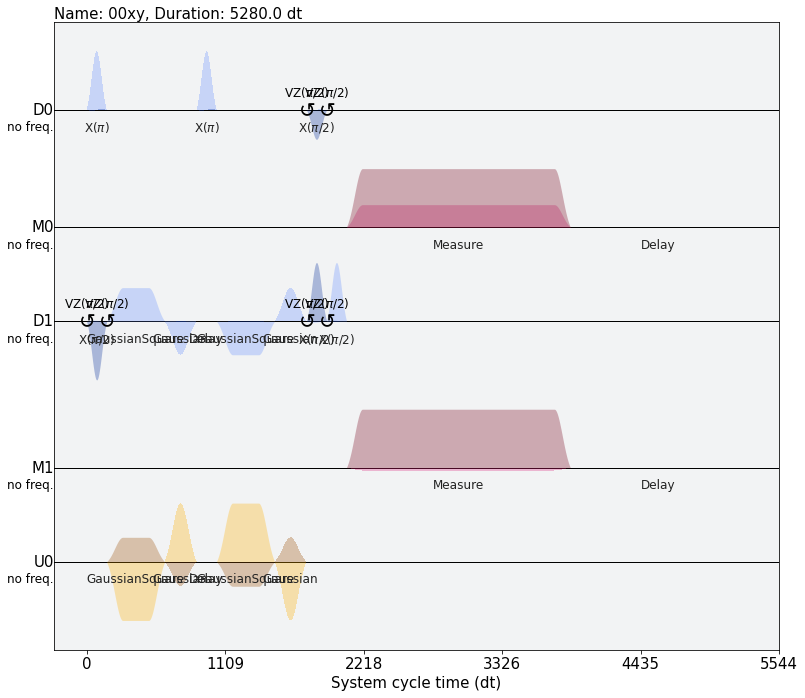

In [17]:
li_schedules['00xy'][23].draw()

In [18]:
jobs = []
#for exp_name, experiment in [('cx', cx_schedules), ('pe', pe_schedules), ('li', li_schedules)]:
for exp_name, experiment in [('cx', cx_schedules)]:
    with open('job_ids_{}.txt'.format(exp_name), 'w') as out:
        for control_initial in initials:
            for target_initial in initials:
                schedules = []
                for control_axis in axes:
                    for target_axis in axes:
                        name = control_initial + target_initial + control_axis + target_axis
                        schedules += experiment[name]
                        
                job = backend.run(schedules, meas_level=2, shots=2048)
                print('{}_{}{} {}'.format(exp_name, control_initial, target_initial, job.job_id()))
                out.write('{}_{}{} {}\n'.format(exp_name, control_initial, target_initial, job.job_id()))
                jobs.append(job)

/usr/local/lib/python3.8/dist-packages/qiskit/compiler/assembler.py:309: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  warnings.warn("Dynamic rep rates are supported on this backend. 'rep_delay' will be "


cx_00 613ee9aafd18232d6a858c8d
cx_01 613ee9ca5d4556432c254ef6
cx_0+ 613ee9dee3f915bf8e3494b2
cx_0i 613ee9fbbc3065418b4936c9
cx_10 613eea19a92e50e7d510e83a
cx_11 613eea3901ea114cd3c30cd7
cx_1+ 613eea6017e5882219ba5961
cx_1i 613eea7888745f6238b9ee2a
cx_+0 613eea9621fb76faf877c4c2
cx_+1 613eeab8822822a2a0e22381
cx_++ 613eead101ea118195c30cdb
cx_+i 613eeaf1bc3065843d4936d3
cx_i0 613eeb0e88745f14e6b9ee36
cx_i1 613eeb35fd18235122858c99
cx_i+ 613eeb5dbc30654bb44936d4
cx_ii 613eeb7b17e5885f44ba5968
